<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">I. Introduction</h1>

<p>
Dans ce notebook, nous nous concentrons sur l’<b>exploration des images</b> du jeu
de données Rakuten. Les images constituent une source d’information essentielle
pour la classification des produits, en particulier lorsque les indices
textuels sont ambigus ou incomplets. L’objectif principal de cette première
étape est donc de <b>mieux comprendre le contenu visuel</b> des données à notre
disposition.
</p>

<p>
Cette phase exploratoire vise à analyser les <b>caractéristiques visuelles
globales</b> des images, telles que les formes, les textures et les couleurs, mais
aussi à identifier les sources de variabilité (qualité, cadrage, fond,
résolution). Ces observations permettent de guider les choix méthodologiques en
matière de <b>prétraitement</b> et de <b>feature engineering</b>.
</p>

<p>
Sur la base de cette analyse, nous mettons en place une <b>préparation des
données images</b> incluant le recadrage, le redimensionnement et la normalisation
nécessaires à l’extraction de descripteurs visuels robustes et comparables. Ces
transformations visent à réduire le bruit tout en conservant l’information
pertinente pour la tâche de classification.
</p>

<p>
Les résultats de cette phase serviront directement à la construction d’un
<b>premier modèle de référence</b> basé sur les images seules. Ce modèle permettra
d’évaluer la capacité des informations visuelles à discriminer les catégories de
produits et constituera un <b>point de départ</b> pour les étapes suivantes du
projet, notamment l’ajout d’autres modalités et les stratégies de fusion.
</p>

</div>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">II. Préparation des données</h1>


<p>
Nous commençons ce notebook par l’<b>importation des données</b> images associées
au jeu de données. Cette étape permet de vérifier la bonne disponibilité des
fichiers et d’obtenir une première vision globale du volume et de la diversité
des images à traiter.
</p>

<p>
Avant toute analyse approfondie, nous procédons à une <b>détection des images
dupliquées</b> à l’aide de techniques de <b>hashage perceptuel</b>. Cette approche
consiste à représenter chaque image sous la forme d’une empreinte compacte,
robuste aux légères variations (redimensionnement, compression), afin
d’identifier efficacement les doublons ou quasi-doublons visuels.
</p>

<p>
Le comptage des doublons permet de <b>mieux caractériser la qualité du jeu de
données</b> et d’anticiper d’éventuels biais liés à la surreprésentation de
certaines images. Ces informations sont également utiles pour interpréter plus
finement les résultats des modèles et, le cas échéant, adapter les stratégies de
prétraitement ou d’échantillonnage.
</p>

</div>


In [1]:
import sys
from pathlib import Path
import hashlib

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.frozen import FrozenEstimator
from sklearn.calibration import CalibratedClassifierCV

SRC_PATH = "../src/"
sys.path.insert(0, SRC_PATH)

from data import load_data, images_read, CATEGORY_SHORT_NAMES
from visualization import images_grid, plot_features_importance, plot_classification_report
from features.image.contours import get_main_contours

# importation de transformers personnalisés pour les images
from features.image.color import ColorEncoder, MeanRGBTransformer, HistRGBTransformer
from features.image.keypoint import CornerCounter, BoVWTransformer
from features.image.shape import ParallelogramCounter
from features.image.texture import HOGTransformer
from features.image.intensity import MinMaxDiffTransformer
from features.image.transforms import Flattener, Resizer, ProportionTransformer, ImageCleaner, CropTransformer

from features import build_image_features_pipeline

In [2]:
df, y = load_data().values()
df = pd.concat([df['image_path'], y], axis=1)
df['category'] = df['prdtypecode'].replace(CATEGORY_SHORT_NAMES)

In [5]:
# génère le hashage en fonction d'une liste de chemins
def generate_hash(paths):
    hashed_contents = []
    for path in paths:
        if path is None or not Path(path).exists():  #  Vérifie si le fichier existe
            hashed_contents.append(None)  # Pas de fichier → None
        else:
            with open(path, 'rb') as f:
                # Lire le contenu du fichier et calculer le hash SHA1
                hashed_contents.append(hashlib.sha1(f.read()).hexdigest())
    return hashed_contents
df['hashed_image'] = generate_hash(df['image_path'])


In [8]:
ndup_images = df['hashed_image'].duplicated(keep=False).sum()
print(f"Il y a {ndup_images} duplicata d'image.")
df = df.drop_duplicates('hashed_image')

Il y a 8956 duplicata d'image.


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’analyse par hashage met en évidence la présence de <b>8&nbsp;956 images
dupliquées</b> dans le jeu de données. Ce volume non négligeable confirme
l’existence de doublons ou quasi-doublons visuels, susceptibles d’introduire des
biais lors de l’entraînement et de l’évaluation des modèles.
</p>

<p>
Afin de mieux comprendre la nature de ces images et d’explorer visuellement le
jeu de données, nous procédons ensuite à l’<b>affichage d’exemples d’images</b>.
Les images sont chargées à l’aide de la fonction <code>images_read</code>, puis
organisées sous forme de <b>grilles</b> à l’aide de la fonction
<code>images_grid</code>, ce qui permet d’analyser rapidement leur contenu, leur
qualité et leur diversité.
</p>

</div>


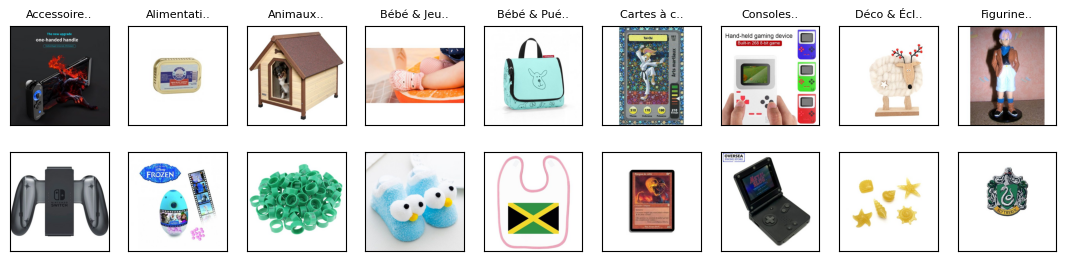

----------------------------------------------------------------------------------------------------------------------------------------------------


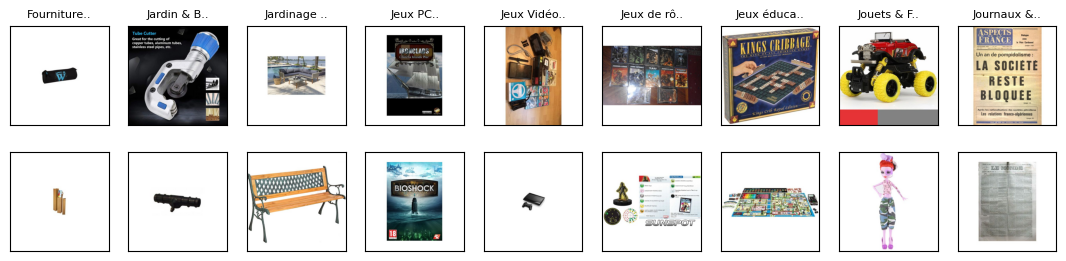

----------------------------------------------------------------------------------------------------------------------------------------------------


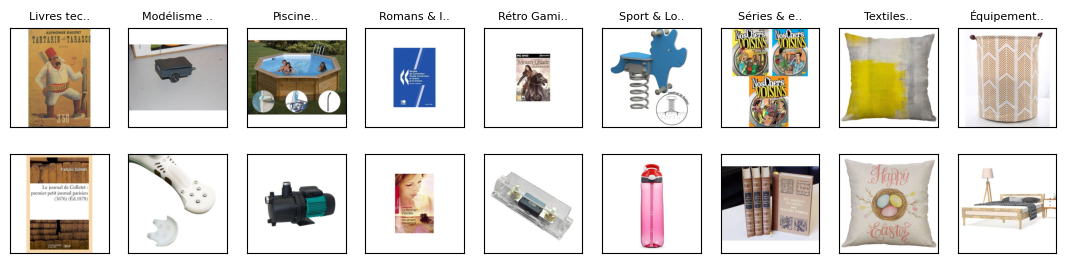

In [3]:
N = 2  # nombre d'images par catégories

titles = []
paths = []

for cat in np.sort(df['category'].unique()):
    titles += [cat[:10]+'..'] + [''] * (N-1)
    paths += list(df[df['category'] == cat]['image_path'].sample(N, random_state=0))
# on utilise une fonction qui nous permet de récupérer le vecteur image correspondant aux chemins
images = images_read(paths)
images_grid(images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

In [9]:
im = images[18]

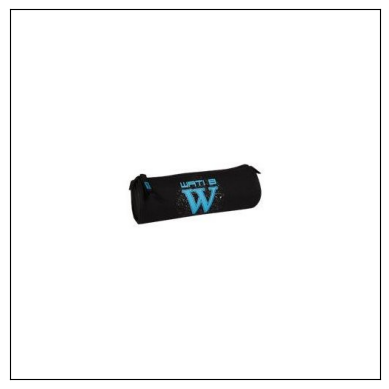

In [10]:
plt.imshow(im)
plt.xticks([])
plt.yticks([]);

In [13]:
cropper = CropTransformer()
cropped_im = cropper.fit_transform(np.array([im]))[0]

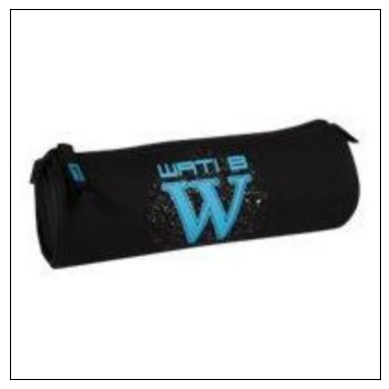

In [14]:
plt.imshow(cropped_im)
plt.xticks([])
plt.yticks([]);

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
<p>
La majorité des images présentent un <b>fond blanc</b>, bien que cela ne soit pas
systématique. On observe également une <b>forte variabilité du cadrage</b> :
certains objets occupent une grande partie de l’image, tandis que d’autres
apparaissent très petits ou peu centrés.
</p>

<p>
Avant de poursuivre l’analyse visuelle et l’extraction de features, nous
appliquons un <b>recadrage automatique</b> afin de recentrer les images sur
l’objet principal et de réduire l’influence du fond.
</p>

<p>
Pour ce faire, nous commençons par détecter les <b>contours principaux</b> à l’aide
de la fonction <code>get_main_contours</code>
(<a href="https://beautiful-pixel.github.io/DS_rakuten/api/features.image.html#features.image.contours.get_main_contours" target="_blank">voir documentation</a>).
Cette fonction prend une image en entrée et applique les étapes suivantes :
</p>

<ol>
  <li>Application d’un <b>flou gaussien</b> afin d’atténuer les petites
      imperfections et le bruit.</li>
  <li>Utilisation du <b>filtre de Canny</b> pour détecter les contours.</li>
  <li>Une <b>dilatation suivie d’une érosion</b> afin de combler les petits trous
      dans les contours détectés.</li>
</ol>

<p>
Les contours sont ensuite extraits à l’aide de <code>cv2.findContours</code> en mode
hiérarchique (<code>cv2.RETR_TREE</code>), et seuls les <b>contours principaux</b> sont
conservés.
</p>

<p>
Enfin, les contours trop plats, approximables par un simple segment, sont
écartés grâce au paramètre <code>min_vertex=3</code>, afin de ne conserver que des
formes pertinentes pour le recadrage.
</p>

</div>



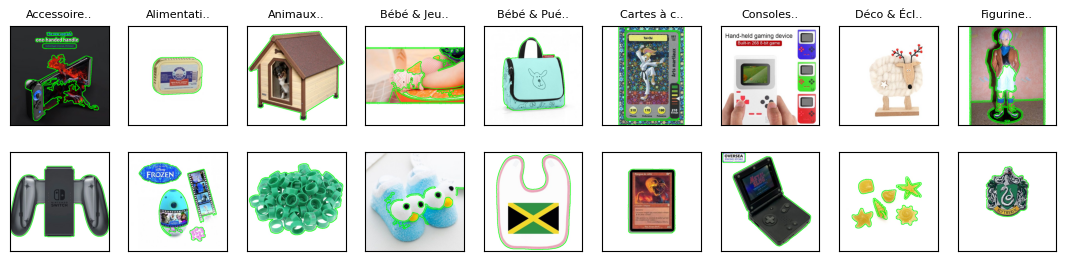

----------------------------------------------------------------------------------------------------------------------------------------------------


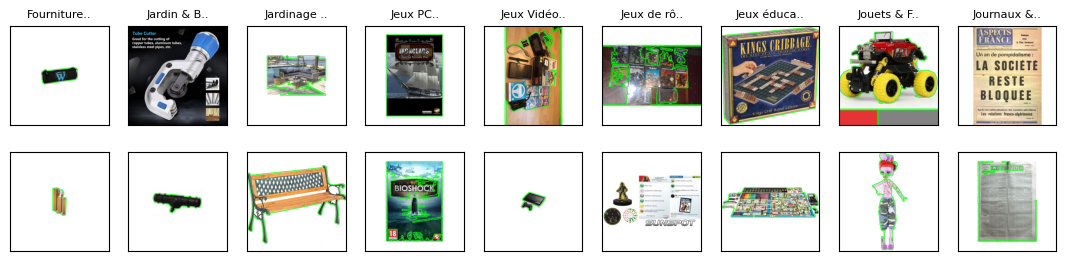

----------------------------------------------------------------------------------------------------------------------------------------------------


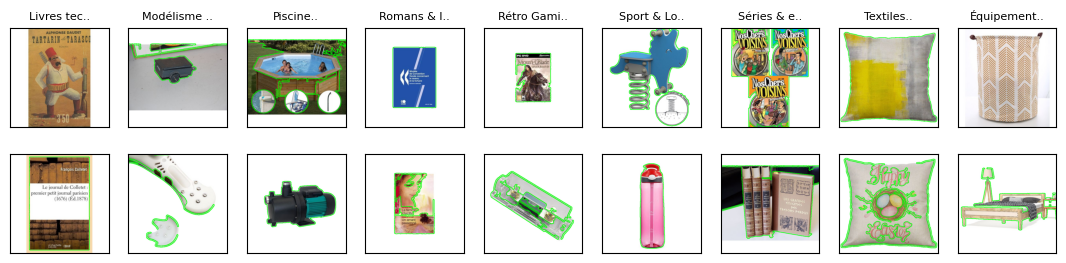

In [4]:
contours = get_main_contours(images, min_len=100, min_vertex=3, n_max_contours=7)
im_with_contours = []
for im, conts in zip(images, contours):
    im_copy = im.copy()
    cv2.drawContours(im_copy, conts, contourIdx=-1, color=(0, 255, 0), thickness=2)  # contour en vert
    im_with_contours.append(im_copy)
images_grid(im_with_contours[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(im_with_contours[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(im_with_contours[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Nous procédons maintenant au <b>masquage de l’arrière-plan</b> lorsque les contours
de l’objet principal sont correctement détectés. Cette étape permet de réduire
l’influence du fond et de se concentrer sur les informations visuelles réellement
pertinentes pour la classification.
</p>

<p>
Afin d’éviter de masquer l’intégralité de l’image dans les cas où les contours
détectés sont incomplets ou trop plats, nous imposons un <b>seuil maximal de
surface à masquer</b>. Concrètement, si la zone à masquer dépasse <b>80&nbsp;% de
la surface totale</b> de l’image, aucun masquage n’est appliqué.
</p>

<p>
Lorsque le masquage est jugé valide, l’image est également <b>recadrée autour du
ou des contours détectés</b>, ce qui permet de recentrer automatiquement l’objet
et d’améliorer la cohérence des entrées pour les étapes suivantes.
</p>

<p>
L’ensemble de ces opérations est implémenté au sein du transformer
<code>ImageCleaner</code>
(<a href="https://beautiful-pixel.github.io/DS_rakuten/api/features.image.html#features.image.transforms.ImageCleaner" target="_blank">voir documentation</a>),
utilisé dans la phase de préparation des images.
</p>

</div>


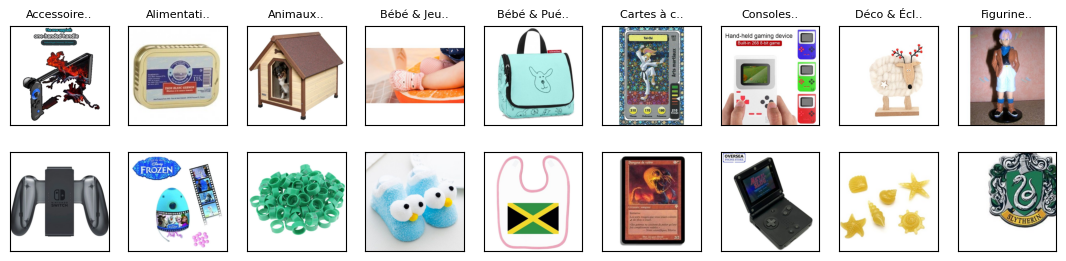

----------------------------------------------------------------------------------------------------------------------------------------------------


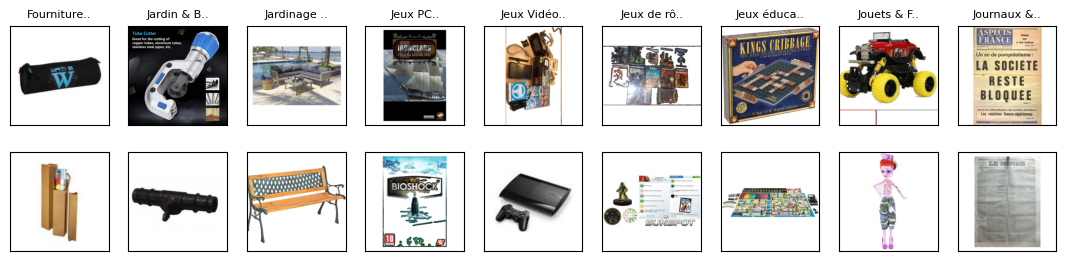

----------------------------------------------------------------------------------------------------------------------------------------------------


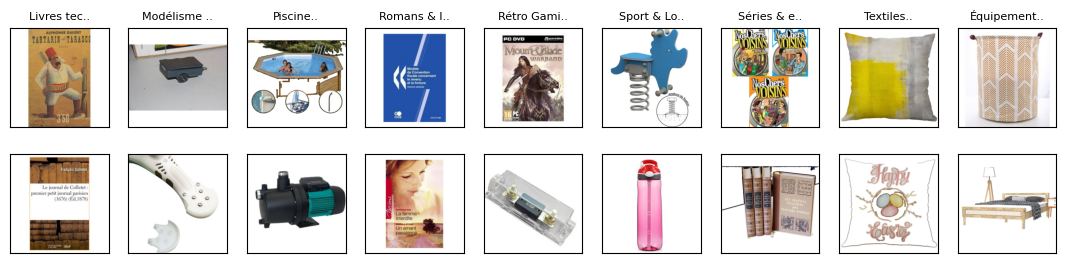

In [5]:
cleaner = ImageCleaner(max_bg_ratio=0.8, white_bg=True, padding=15, min_len_ratio=0.2, min_vertex=3, n_max_contours=6)
cropped_images = cleaner.fit_transform(images)

images_grid(cropped_images[:9*N], N, 9, titles=titles[:9*N], ordered_by_rows=False)
print('-'*148)
images_grid(cropped_images[9*N:18*N], N, 9, titles=titles[9*N:18*N], ordered_by_rows=False)
print('-'*148)
images_grid(cropped_images[18*N:], N, 9, titles=titles[18*N:], ordered_by_rows=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Malgré quelques loupés ponctuels dans la détection des contours, le nettoyage et
le masquage permettent d’obtenir des images globalement <b>moins polluées par
l’environnement</b> du produit, facilitant ainsi leur analyse visuelle.
</p>

<p>
Afin d’analyser les images <b>par catégorie de produits</b>, nous faisons le choix
de travailler sur des <b>matrices d’images regroupées par catégorie</b> plutôt que
de charger les fichiers JPEG individuellement. Cette approche permet de réduire
considérablement le temps de chargement et de manipulation des données, tout en
facilitant les analyses exploratoires à l’échelle d’une catégorie.
</p>

<p>
Chaque catégorie est ainsi représentée par une <b>matrice NumPy</b> contenant
l’ensemble des images correspondantes, prétraitées de manière homogène
(redimensionnement et nettoyage). Ces matrices constituent une base efficace
pour la visualisation sous forme de grilles, l’analyse comparative entre
catégories et les étapes ultérieures de feature engineering.
</p>

</div>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">II. Analyse des couleurs</h1>

<p>
Nous nous intéressons désormais à l’<b>analyse des couleurs</b> présentes dans les
images, un élément clé pour la discrimination de certaines catégories de
produits. La couleur constitue en effet une information visuelle forte, souvent
liée à la nature du produit, à son packaging ou à son usage.
</p>

<p>
L’objectif de cette section est d’étudier la <b>répartition des couleurs par
catégorie</b>, afin d’identifier d’éventuelles signatures chromatiques
caractéristiques et d’évaluer dans quelle mesure cette information peut être
exploitée par les modèles de classification.
</p>

<h2>2.1 Distribution des intensités par canal</h2>

<p>
Dans un premier temps, nous analysons la <b>distribution des intensités</b> pour
chacun des canaux <b>R, G et B</b>. Pour cela, nous calculons des
<b>histogrammes RGB</b> à l’aide de la fonction <code>calcHist</code> d’OpenCV, à partir
des <b>vecteurs d’images regroupés par catégorie</b>.
</p>

<p>
Ces histogrammes permettent de visualiser la contribution relative de chaque
canal de couleur, de comparer les profils chromatiques entre catégories et de
mettre en évidence des dominantes ou des contrastes susceptibles d’améliorer la
séparation entre classes.
</p>

</div>


In [6]:
# fonction permettant de récupérer l'histogramme sur l'ensembles des images passé en entrée

def get_rgb_hist(images):
    hist = np.zeros((3,256,1))
    for im in images:
        for channel in [0,1,2]:
            hist[channel] += cv2.calcHist([im],[channel],None,[256],[0,256])
    return hist

categories = np.array(sorted(df['category'].unique()))
# on récupère les codes ordonnés selon l'ordre des noms de catégorie
codes = np.array([
    df[df['category']==cat]['prdtypecode'].iloc[0]
    for cat in categories
])
# liste vide qui permettra de charger un histogramme par catégorie
hists = []
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # puis on ajoute l'histogramme retourner par la fonction get_rgb_hist
    hists.append(get_rgb_hist(X))
hists = np.array(hists)

-----------------------------------------------------------------  histogrammes RGB  -----------------------------------------------------------------


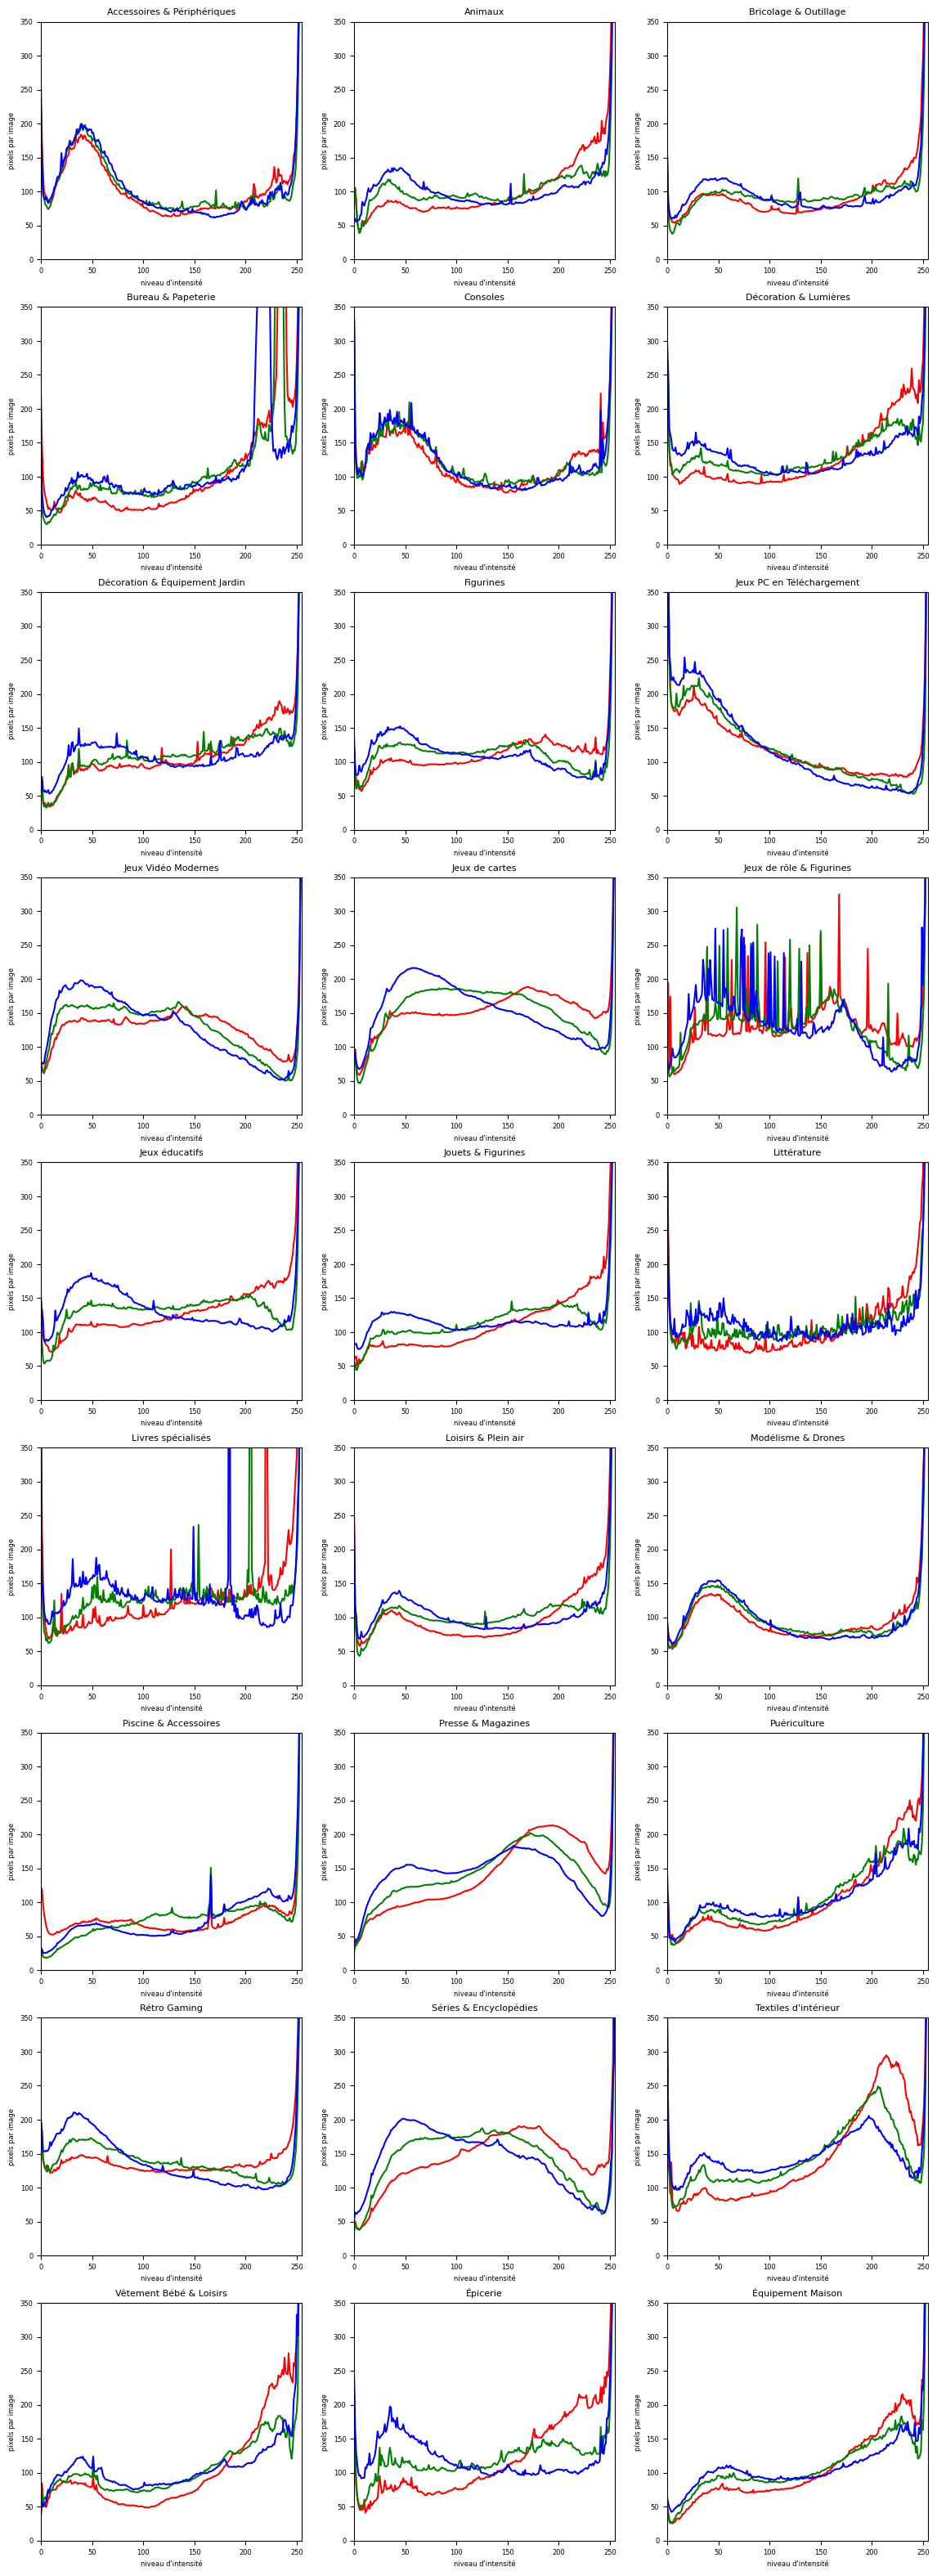

In [7]:
print('-'*65+"  histogrammes RGB  "+'-'*65)

cat_len = [len(df[df['category']==cat]) for cat in categories]

fig, axes = plt.subplots(9, 3, figsize=(14,40))
for i, ax in enumerate(axes.flatten()):
    for c, h in zip('rgb', hists[i]):
        n_images = cat_len[i]
        ax.plot(range(256), h / n_images, color=c)
        ax.set_title(categories[i], fontsize=8)
        ax.xaxis.set_tick_params(labelsize=6)
        ax.yaxis.set_tick_params(labelsize=6)
        ax.set_xlabel('niveau d\'intensité', fontsize=6)
        ax.set_ylabel('pixels par image', fontsize=6)
        ax.set_xlim(0,255)
        ax.set_ylim(0,350)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
On observe que certaines catégories présentent des <b>images globalement plus
sombres</b>, en particulier celles liées aux univers des consoles et du jeu vidéo
telles que <i>Accessoires</i>, <i>Rétro Gaming</i>, <i>Jeux PC</i> et
<i>Jeux vidéo</i>.
</p>

<p>
Dans la majorité des catégories, la <b>composante rouge</b> est dominante, tandis
que le <b>canal bleu</b> est généralement moins représenté. Ce phénomène est
notamment visible pour les catégories <i>Séries &amp; encyclopédies</i>,
<i>Presse &amp; magazines</i> et <i>Textiles d’intérieur</i>. À l’inverse, la
catégorie <i>Piscine</i> se distingue par une <b>forte présence du bleu</b>,
cohérente avec la nature des produits associés.
</p>

<p>
On remarque également des différences dans la <b>structure des histogrammes</b> :
certaines catégories, comme <i>Littérature</i> ou <i>Livres spécialisés</i>,
présentent de <b>nombreux pics marqués</b>, tandis que d’autres, telles que
<i>Presse &amp; magazines</i>, affichent des distributions beaucoup plus
<b>lisses</b>.
</p>

<p>
Afin de mieux comprendre l’origine de ces variations, nous allons maintenant
examiner plus en détail à quoi correspondent les <b>trois pics de plus forte
intensité</b> observés pour la catégorie <i>Livres spécialisés</i>.
</p>

</div>


In [8]:
hist = hists[categories == 'Livres spécialisés']
print("rouge (219 - 222)")
print(hist[0,0,219:223])
print("vert (203 - 206)")
print(hist[0,1,203:207])
print("bleu (183 - 185)")
print(hist[0,2,183:186])

rouge (219 - 222)
[[ 460851.]
 [2577274.]
 [1050146.]
 [ 403741.]]
vert (203 - 206)
[[ 387603.]
 [1111571.]
 [2613460.]
 [ 440215.]]
bleu (183 - 185)
[[ 401978.]
 [3097007.]
 [ 376218.]]


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les principaux pics observés correspondent à des intensités de
<b>220</b>, <b>205</b> et <b>184</b> pour les canaux <b>rouge</b>, <b>vert</b> et
<b>bleu</b> respectivement.
</p>

<p>
Afin de comprendre l’origine de ces pics, nous cherchons à déterminer :
</p>

<ul>
  <li>si ces intensités apparaissent sur les <b>mêmes pixels</b>,</li>
  <li>si la <b>couleur résultante</b> est récurrente au sein de nombreuses images,</li>
  <li>et si elle est associée à des <b>types de produits similaires</b>.</li>
</ul>

<p>
Pour ce faire, nous filtrons les produits pour lesquels <b>plus de 30&nbsp;% des
pixels</b> présentent cette couleur, afin d’identifier les images contribuant
le plus fortement à ces pics d’intensité.
</p>

</div>


nombre de pixels de la couleur (220,205,184) dans les livres spécialisés : 2093984
Cela représente 74.5% des pixels r=220 du pic de vert de l'histogramme rgb
C'est 1.3% des pixels de la catégorie 'Livres spécialisés'


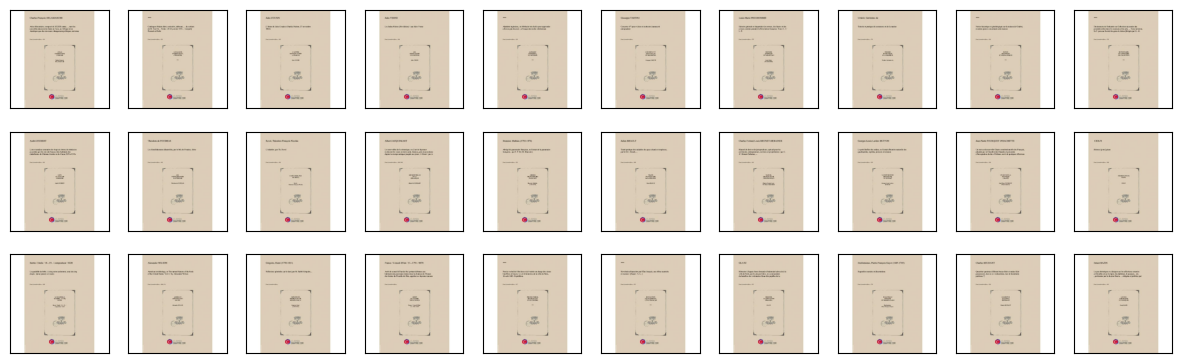

In [9]:
# on récupère les images de la catégorie
code = codes[categories == 'Livres spécialisés'][0]
path = f"../data/exploration/images/{code}.npy"
X = np.load(path)

# on récupère les valeurs des pics
r, g, b = 220, 205, 184
color = np.array([220, 205, 184])

# puis

n_pixs = (X == color).all(axis=3).sum()
print(f"nombre de pixels de la couleur (220,205,184) dans les livres spécialisés : {n_pixs}")
print(f"Cela représente {n_pixs/2810333:.1%} des pixels r=220 du pic de vert de l'histogramme rgb")
print(f"C'est {n_pixs/ (X.shape[0]*X.shape[1]*X.shape[2]):.1%} des pixels de la catégorie 'Livres spécialisés'")

rate_by_im = (X == color).all(axis=3).sum(axis=2).sum(axis=1) / (X.shape[1]*X.shape[2])
mask = rate_by_im > 0.3
images_grid(X[mask],3)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
<p>
On constate que cette couleur est <b>caractéristique de nombreux manuscrits</b>,
largement représentés dans la catégorie <i>Livres spécialisés</i>. Ces produits
expliquent ainsi la présence des <b>trois pics marqués</b> observés sur
l’histogramme de cette catégorie.
</p>

<p>
Lorsqu’une image contient un objet de <b>couleur quasi uniforme</b>, c’est-à-dire
avec peu ou pas de variation de teinte (image très monochrome), son histogramme
présente un <b>pic prononcé</b> aux intensités correspondant à cette couleur sur
les trois canaux RGB. Afin d’identifier ce type d’objets, il est possible
d’analyser les <b>variations maximales du nombre de pixels</b> entre intensités
successives : des variations élevées traduisent la présence de pics marqués dans
l’histogramme. Lorsque ces pics sont observés simultanément sur les trois
canaux, cela indique qu’une part importante de l’image est effectivement
monochrome.
</p>

<p>
Pour exploiter cette information, nous utilisons les transformateurs
<code>HistRGBTransformer</code>, qui génère le vecteur d’histogrammes RGB à partir des
images en entrée, et <code>MinMaxDiffTransformer</code>, qui extrait la valeur minimale
des différences maximales sur les intervalles de colonnes correspondant à chaque
canal. Nous analyserons ensuite les <b>valeurs moyennes obtenues par catégorie</b>.
Afin d’éviter de capturer des pics liés aux arrière-plans très clairs ou très
sombres, l’analyse est restreinte aux <b>intervalles d’intensité compris entre
15 et 240</b> pour chacun des canaux RGB.
</p>

</div>


In [9]:
# liste vide qui permettra de charger un histogramme par catégorie

m, M = 15, 240
# les intervalles ou l'on regarde les différences max
max_diff_ranges = [[i*(M-m), (i+1)*(M-m)] for i in range(3)]
mean_min_max_pics = []
histrgb = HistRGBTransformer(histSize=[M-m], ranges=[[m,M]]*3)
min_max_diff = MinMaxDiffTransformer(max_diff_ranges=max_diff_ranges)
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # puis on ajoute l'histogramme retourner par la fonction get_rgb_hist
    X = histrgb.fit_transform(X)
    X = min_max_diff.fit_transform(X)
    mean_min_max_pics.append(X.mean())
mean_min_max_pics = np.array(mean_min_max_pics)


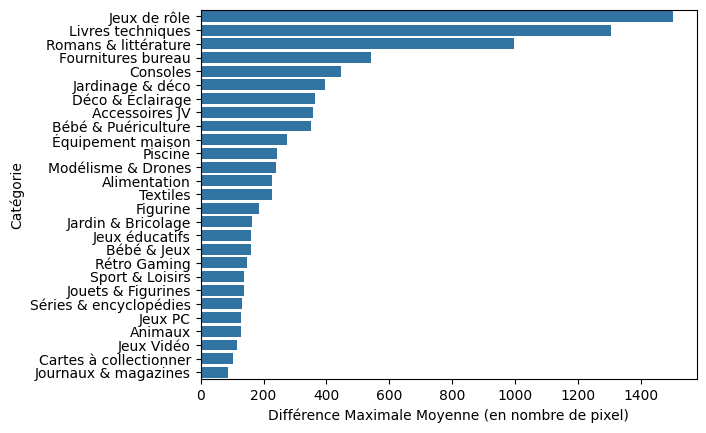

In [11]:
data = pd.DataFrame({'Catégorie':categories, 'Différence Maximale Moyenne':mean_min_max_pics}).sort_values(
    'Différence Maximale Moyenne', ascending=False
)
sns.barplot(data=data, x='Différence Maximale Moyenne', y='Catégorie', orient='h')
plt.xlabel('Différence Maximale Moyenne (en nombre de pixel)');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les résultats obtenus sont <b>cohérents avec les observations précédentes</b>
issues de l’analyse des histogrammes RGB. Les catégories présentant les
<b>différences maximales moyennes les plus élevées</b> sont
<i>Jeux de rôle</i>, <i>Livres techniques</i> et <i>Romans &amp; littérature</i>,
ce qui indique la présence fréquente de <b>pics d’intensité marqués</b> sur les
trois canaux de couleur.
</p>

<p>
Ces valeurs élevées traduisent une forte proportion d’images contenant des
<b>zones de couleur quasi uniforme</b>, souvent associées à des objets
monochromes ou à des fonds dominants caractéristiques (par exemple des
couvertures de livres ou des manuscrits). À l’inverse, les catégories présentant
des valeurs plus faibles, comme <i>Journaux &amp; magazines</i> ou
<i>Cartes à collectionner</i>, montrent des distributions de couleur plus
<b>diffuses et variées</b>, sans pics dominants marqués.
</p>

<p>
Cette analyse confirme que la <b>structure des histogrammes de couleur</b>
constitue une information discriminante pour certaines catégories. En
conséquence, nous retenons ces mesures comme <b>features couleur</b> pour notre
modèle de classification.
</p>

<p>
Plus précisément, nous utilisons :
</p>

<ul>
  <li>les <b>différences maximales extraites des histogrammes RGB</b>, afin de
      capturer la présence de pics d’intensité caractéristiques,</li>
  <li>ainsi que des <b>histogrammes RGB découpés en 16 intervalles</b>, permettant
      de représenter plus finement la distribution globale des couleurs.</li>
</ul>

<p>
Ces features couleur viendront compléter les autres descripteurs visuels et
participeront à la construction du <b>premier modèle de base</b>.
</p>

</div>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>2.2 Segmentation des couleurs dans les images</h2>

<p>
Jusqu’ici, nous avons analysé la <b>distribution des intensités</b> de chaque canal
(<b>rouge</b>, <b>vert</b>, <b>bleu</b>) à l’aide des histogrammes RGB. Cette approche
permet de mettre en évidence certaines tendances globales, comme la présence de
pics d’intensité, mais elle ne décrit que partiellement la <b>couleur réelle des
pixels</b>, un pixel étant défini par la combinaison simultanée des trois canaux.
</p>

<p>
Afin d’obtenir une représentation plus fidèle des couleurs effectivement
présentes dans les images, nous passons à une analyse dans l’<b>espace colorimétrique
3D (R, G, B)</b>. Plutôt que de considérer les canaux indépendamment, les pixels
sont regroupés selon des <b>intervalles définis dans cet espace</b>, chacun
correspondant à une couleur perceptuelle : noir, blanc, gris, rouge, orange,
jaune, vert, turquoise, cyan, bleu, violet et rose.
</p>

<p>
Concrètement, chaque pixel est <b>encodé</b> en fonction de l’intervalle auquel il
appartient. Cette approche permet d’identifier les <b>couleurs dominantes par
catégorie</b> d’images, de manière plus cohérente avec la <b>perception humaine</b>
que l’analyse canal par canal.
</p>

<p>
Pour réaliser cet encodage, nous utilisons la classe <code>ColorEncoder</code>. À titre
illustratif, nous présentons ci-dessous quelques exemples d’images
<b>recolorées</b>, dans lesquelles chaque pixel prend la couleur représentative du
centre de l’intervalle auquel il a été associé.
</p>

</div>


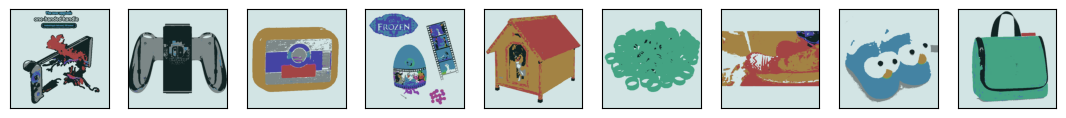

----------------------------------------------------------------- sans recoloration -----------------------------------------------------------------


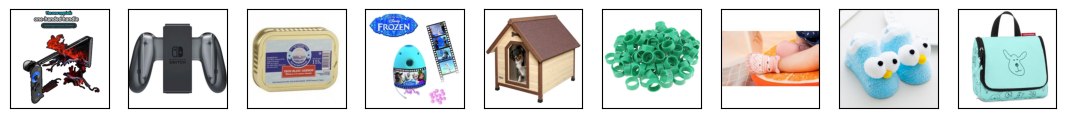

In [6]:
encoder = ColorEncoder()
enc_images = encoder.fit_transform(cropped_images)
# on récupère la couleur centrale de chaque intervalle de couleur définit dans l'encoder de couleur
rgb_centroids = encoder.get_centroids(rgb=True)
centroids_images = rgb_centroids[0][enc_images]
images_grid(centroids_images[:9], 1, 9)
print('-'*65 +' sans recoloration '+'-'*65)
images_grid(cropped_images[:9], 1, 9)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Nous analysons désormais, pour chaque catégorie de produits, la <b>proportion de
pixels</b> appartenant à chacune des <b>classes de couleurs</b> définies
précédemment. Cette étape permet de mettre en évidence les <b>teintes
dominantes</b> au sein des catégories et de comparer leurs profils chromatiques.
</p>

<p>
L’étude de ces proportions fournit une représentation synthétique et
interprétable de la composition colorimétrique des images, et constitue une base
pertinente pour la construction de <b>features couleur</b> exploitables par les
modèles de classification.
</p>

</div>


In [9]:
# permet de récupérer les proportions parmis toutes les valeurs encodées
prop_all = ProportionTransformer()
# permet de récupérer les proportions parmis toutes les valeurs encodées (hormis noir, gris, blanc qui sont encodé par 0,1,2)
prop_only_colors = ProportionTransformer(categories=range(3,12))

# liste vide qui permettra de charger un histogramme par catégorie
rates = []
rates_only_colors = []
# pour que ça ne soit pas trop long
resizer = Resizer(dsize=(64,64))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    X = resizer.fit_transform(X)
    X = encoder.transform(X).reshape(len(X), -1)
    # on récupère les proportions moyennes
    X_all = prop_all.fit_transform(X)
    rates.append(X_all.mean(axis=0))
    X_only_colors = prop_only_colors.fit_transform(X)
    rates_only_colors.append(X_only_colors.mean(axis=0))

rates = np.array(rates)
rates_only_colors = np.array(rates_only_colors)

# ici on normalise car le tranformateur renvoie un vecteur nul pour chaque image
# ou aucune couleur n'est présente
rates_only_colors = (rates_only_colors / rates_only_colors.sum(axis=1).reshape(27,1))

In [10]:
idx1 = np.argsort(rates[:,:3].sum(axis=1))
rates = rates[idx1]

idx2 = np.argsort(rates_only_colors[:,:5].sum(axis=1))
rates_only_colors = rates_only_colors[idx2]

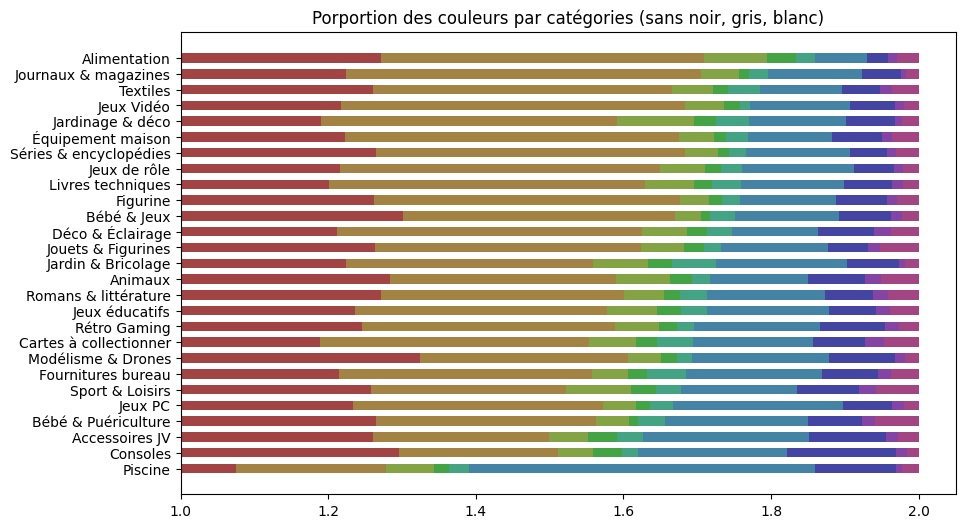

In [15]:
#fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,12))

fig, ax2 = plt.subplots(1,1,figsize=(10,6))

# bottom = np.zeros(len(categories))
# for color_code in range(rates.shape[1]):
#     r, g, b = rgb_centroids[0][color_code]/255
#     ax1.barh(categories[idx1], rates[:,color_code], left=bottom, height=0.6, color=(r,g,b))
#     bottom += rates[:,color_code]
# ax1.set_title('Porportion des couleurs par catégories (avec noir, gris, blanc inclus)')
# #plt.xticks(rotation=90)
# #plt.show()
# bottom = np.zeros(len(categories))

for color_code in range(rates_only_colors.shape[1]):
    # l'encodage des couleurs commence après blanc, gris, noir donc à partir de 3.
    r, g, b = rgb_centroids[0][color_code+3]/255
    ax2.barh(categories[idx2], rates_only_colors[:,color_code], left=bottom, height=0.6, color=(r,g,b))
    bottom += rates_only_colors[:,color_code]
ax2.set_title('Porportion des couleurs par catégories (sans noir, gris, blanc)')
# plt.xticks(rotation=90)
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’analyse des <b>proportions de couleurs</b> met en évidence des différences nettes
entre les catégories. Certaines d’entre elles présentent des images
<b>globalement plus colorées</b>, avec une répartition marquée entre plusieurs
teintes dominantes, comme <i>Cartes à collectionner</i>, <i>Jeux de rôle</i> ou
<i>Livres techniques</i>.
</p>

<p>
Dans la majorité des catégories, les couleurs <b>chaudes</b> (rouge, orange,
jaune) sont prédominantes, traduisant la forte présence de packagings ou de
supports imprimés. À l’inverse, certaines catégories se distinguent par une
<b>signature chromatique spécifique</b> : la catégorie <i>Piscine</i> présente
ainsi une proportion de <b>bleu</b> nettement plus élevée que les autres, en
cohérence avec la nature des produits associés.
</p>

<p>
La répartition des couleurs est globalement <b>équilibrée mais différenciée</b>
selon les catégories, ce qui suggère que ces proportions capturent une
information visuelle pertinente et discriminante. En conséquence, les
<b>proportions de couleurs par catégorie</b> constituent des <b>features
intéressantes</b> à conserver pour le modèle, car elles offrent une
représentation synthétique, interprétable et complémentaire des autres
descripteurs visuels.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">III. Détection des formes</h1>

<h2>3.1 Analyse des moyennes d’intensité</h2>

<p>
Après l’analyse des couleurs, nous nous intéressons désormais à la
<b>détection des formes</b> présentes dans les images. Contrairement aux couleurs,
les formes sont moins sensibles aux variations d’illumination et constituent
souvent un <b>indice visuel structurant</b> pour différencier certaines
catégories de produits.
</p>

<p>
Dans un premier temps, nous analysons les <b>images moyennes</b> et les
<b>écart-types d’intensité</b> calculés par catégorie. Ces représentations
agrégées permettent de mettre en évidence des <b>structures récurrentes</b> :
zones fréquemment occupées par l’objet, contours dominants ou régions présentant
une forte variabilité visuelle.
</p>

<p>
L’image moyenne donne une indication sur la <b>forme globale</b> et la
localisation typique des objets au sein des images, tandis que l’image
d’écart-type met en évidence les zones où la variabilité est la plus forte,
souvent associées aux bords, aux détails ou aux différences de cadrage.
</p>

<p>
L’objectif de cette première analyse est d’évaluer si des <b>motifs de forme
distinctifs</b> émergent à l’échelle des catégories, justifiant l’utilisation de
descripteurs de forme et de texture dans le modèle de classification.
</p>

</div>



-----------------------------------------------------------------  moyennes  -----------------------------------------------------------------


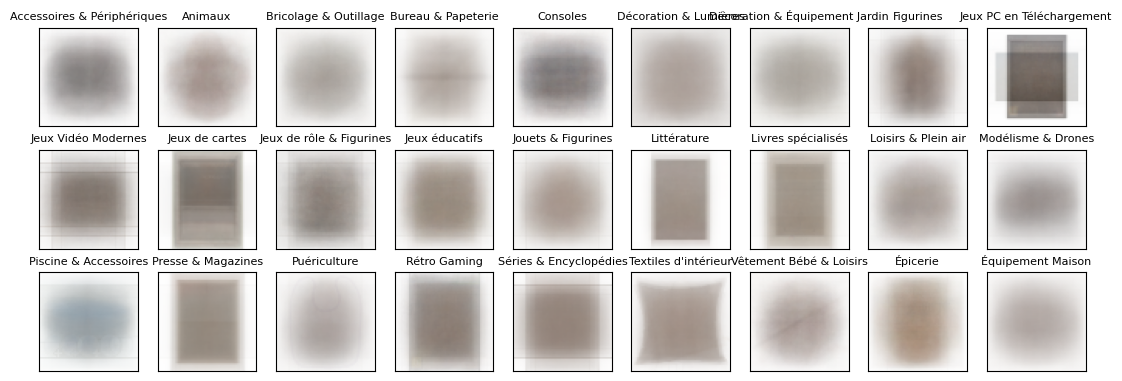

-----------------------------------------------------------------  écart-types  -----------------------------------------------------------------


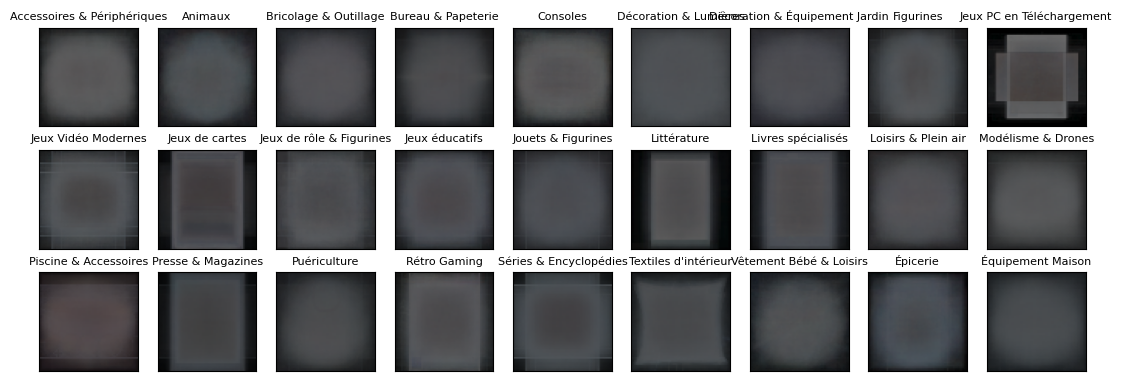

In [26]:
images_means = []
images_std = []

resizer = Resizer(dsize=(64,64))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # on reduit les images pour éviter que les calculs qui suivent soit trop long
    X = resizer.fit_transform(X)
    # on récupère la moyenne des images et leurs écart-types
    images_means.append(X.mean(axis=0).astype('uint8'))
    images_std.append(X.std(axis=0).astype('uint8'))

print('-'*65+"  moyennes  "+'-'*65)
images_grid(images_means, 3, 9, titles=categories)
print('-'*65+"  écart-types  "+'-'*65)
images_grid(images_std, 3, 9, titles=categories)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’image moyenne de la catégorie <em>Piscine</em> confirme les observations issues
de l’analyse des couleurs&nbsp;: elle apparaît globalement plus bleutée, en
cohérence avec la forte proportion de pixels bleus mise en évidence dans les
sections précédentes.
</p>

<p>
Nous constatons également que les catégories pour lesquelles les <b>formes
ressortent le plus nettement</b> sont celles liées aux <em>Livres</em> et aux
<em>Jeux PC</em>. Ces catégories sont majoritairement caractérisées par des
<b>formes rectangulaires</b>, correspondant aux formats typiques des produits.
On observe par ailleurs plusieurs <b>ratios de rectangles</b>&nbsp;: des formes
proches du carré dans la catégorie <em>Jeux de cartes</em>, tandis que les objets
de la catégorie <em>Littérature</em> présentent des formats plus allongés.
</p>


<h2>3.2 Détection et classification des parallélogrammes</h2>

<p>
Afin de quantifier les observations sur les formes, nous utilisons le
transformateur <code>ParallelogramCounter</code>
(<a href="https://beautiful-pixel.github.io/DS_rakuten/api/features.image.html#features.image.shape.ParallelogramCounter" target="_blank">voir documentation</a>),
qui permet de <b>détecter et compter les parallélogrammes</b> présents dans les
images.
</p>

<p>
Les parallélogrammes détectés sont classés selon des <b>intervalles de ratios</b>
définis par le rapport <i>longueur / largeur</i>. Cette approche permet de
distinguer différents formats de rectangles et de capturer des
<b>informations de forme discriminantes</b>, en particulier pour des catégories
telles que les livres, les boîtiers de jeux ou les supports imprimés.
</p>

<p>
Le graphique suivant présente, pour chaque catégorie, la
<b>proportion d’images</b> ne contenant <b>aucun</b>, <b>un seul</b> ou
<b>plusieurs parallélogrammes</b> détectés.
</p>

<p>
Cette visualisation permet d’évaluer dans quelle mesure la présence de formes
rectangulaires constitue un <b>signal discriminant exploitable</b> pour la suite
du modèle.
</p>

</div>


In [22]:
# récupère le taux d'image avec aucun rectangle detecté, avec un rectangle detecté ou avec plusieurs rectangles detectés par catégorie
rates = []
shares = []

resizer = Resizer(dsize=(128,128))

for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    # on reduit les images pour éviter que les calculs qui suivent soit trop long
    X = resizer.fit_transform(X)
    X = counter.transform(X)
    # proportion d'image avec 0, 1 ou plusieurs parallèlogrammes detéctés par catégorie
    total = X.sum(axis=1)
    rates.append([(total == 0).mean(), (total == 1).mean(), (total > 1).mean()])
    # parmis les parallèlogrammes les proportions de chaque intervalle de format
    shares.append(X.sum(axis=0)/X.sum())

rates = np.array(rates)
shares = np.array(shares)

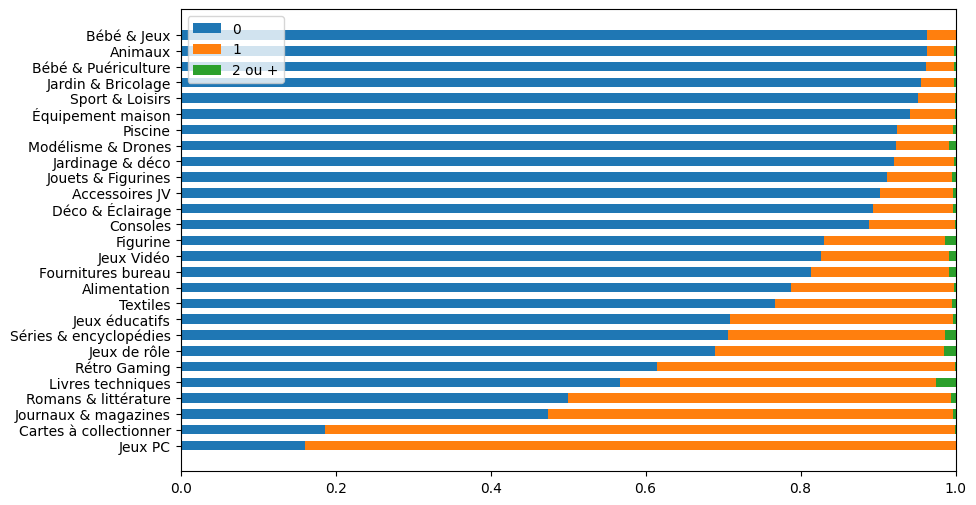

In [28]:
idx1 = np.argsort(rates[:,0])
idx2 = np.argsort(shares[:,:3].sum(axis=1))
colormap = plt.cm.Oranges # Tu peux essayer 'viridis', 'plasma', 'inferno', 'cividis', etc.
colors = [colormap(i / 5) for i in range(1,5)]

# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,12))

fig, ax1 = plt.subplots(1,1,figsize=(10,6))

bottom = np.zeros(len(categories))
labels = ['0', '1', '2 ou +']
for i in range(rates.shape[1]):
    ax1.barh(categories[idx1], rates[idx1][:,i], left=bottom, height=0.6, label=labels[i])
    bottom += rates[idx1][:,i]
ax1.legend()

# bottom = np.zeros(len(categories))
# labels = ['format < 0.5', '0.5 <= format < 0.7', '0.7 <= format < 0.8', 'format >= 0.8']
# for i in range(shares.shape[1]):
#     ax2.barh(categories[idx2], shares[idx2][:,i], left=bottom, height=0.6, label=labels[i], color=colors[i])
#     bottom += shares[idx2][:,i]
# ax2.legend()
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Le graphique met en évidence des différences marquées entre les catégories quant
à la <b>présence de parallélogrammes</b> dans les images. Les catégories
<i>Jeux PC</i> et <i>Cartes à collectionner</i> se distinguent particulièrement :
dans plus de <b>80&nbsp;% des images</b>, au moins un parallélogramme est détecté,
ce qui confirme les observations réalisées à partir des images moyennes.
</p>

<p>
Des catégories comme <i>Romans &amp; littérature</i>, <i>Livres techniques</i> ou
<i>Journaux &amp; magazines</i> présentent également une proportion significative
d’images contenant un parallélogramme, traduisant la forte présence de formats
rectangulaires liés aux couvertures, pages ou supports imprimés.
</p>

<p>
À l’inverse, la majorité des catégories non liées aux supports imprimés
(<i>Animaux</i>, <i>Bébé &amp; Jeux</i>, <i>Jardin &amp; Bricolage</i>, par exemple)
présentent très majoritairement des images sans parallélogramme détecté, ce qui
souligne le caractère <b>discriminant</b> de cette information.
</p>

<p>
Ces résultats suggèrent qu’il est <b>pertinent d’intégrer ces caractéristiques
de forme</b> dans le pipeline final, la présence ou l’absence de
parallélogrammes constituant un signal visuel simple, interprétable et
complémentaire des autres descripteurs utilisés.
</p>

</div>


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>3.3 Détecteur de coins de Harris</h2>

<p>
Pour détecter les <b>points anguleux</b> dans les images, nous utilisons la méthode
de <b>Harris</b>. Ce détecteur repose sur l’analyse des <b>variations locales
d’intensité</b> au sein d’une petite fenêtre&nbsp;: lorsqu’un déplacement du
voisinage dans plusieurs directions entraîne de fortes variations d’intensité,
le point est alors identifié comme un <b>coin</b>.
</p>

<p>
Les coins ainsi détectés correspondent à des <b>points d’intérêt stables et
robustes</b>, souvent situés sur les contours, les intersections de lignes ou les
détails structurés des objets. Ils constituent des indicateurs pertinents pour
caractériser la <b>complexité et la structure</b> des formes présentes dans les
images.
</p>

<p>
Nous allons analyser, pour chaque catégorie, le <b>nombre moyen de points de
Harris détectés</b>. Le graphique suivant permet de comparer la densité de coins
entre catégories et d’évaluer dans quelle mesure cette information constitue un
<b>signal discriminant exploitable</b> pour le modèle.
</p>

</div>


In [ ]:
counter = CornerCounter(block_size=2, ksize=3, threshold=0.05)
counts = []
for code, cat in zip(codes, categories):
    # on charge le vecteur images de la categorie puis on applatit les images
    path = f"../data/exploration/images/{code}.npy"
    X = np.load(path)
    X = counter.fit_transform(X)
    counts.append(X.mean())

counts = np.array(counts)

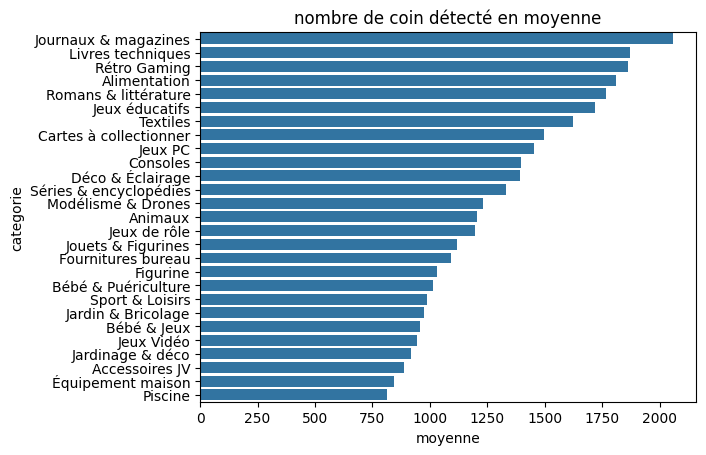

In [32]:
data = pd.DataFrame({'categorie':categories, 'moyenne':counts}).sort_values('moyenne', ascending=False)
sns.barplot(data=data, y='categorie', x='moyenne', orient='h')
plt.title("nombre de coin détecté en moyenne");

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Le graphique met en évidence des différences notables entre les catégories en
termes de <b>nombre moyen de points de Harris détectés</b>. Les catégories
<i>Journaux &amp; magazines</i>, <i>Livres techniques</i> et
<i>Romans &amp; littérature</i> présentent les valeurs les plus élevées, ce qui
traduit une forte densité de <b>détails anguleux</b> liée aux contenus imprimés
(textes, bordures, mises en page).
</p>

<p>
Des catégories comme <i>Jeux PC</i>, <i>Cartes à collectionner</i> ou
<i>Rétro Gaming</i> affichent également des valeurs élevées, reflétant la présence
de nombreux contours et éléments graphiques. À l’inverse, des catégories telles
que <i>Piscine</i>, <i>Équipement maison</i> ou <i>Accessoires JV</i> présentent
un nombre moyen de coins plus faible, indiquant des images visuellement plus
lisses ou dominées par de grandes zones homogènes.
</p>

<p>
Ces résultats confirment que la <b>densité de coins</b> constitue une information
structurante et potentiellement <b>discriminante</b>, complémentaire des
descripteurs de couleur et de forme précédemment étudiés.
</p>

<h2>3.4 Histogrammes de gradients orientés</h2>

<p>
Les descripteurs <b>HOG</b> (<em>Histogram of Oriented Gradients</em>) permettent
de représenter une image en fonction des <b>directions de ses gradients
locaux</b>. Ils mettent en évidence les contours et les formes en comptant la
fréquence des orientations détectées dans de petites régions de l’image.
</p>

<p>
Cette méthode est particulièrement efficace pour capturer la
<b>structure globale</b> d’un objet, tout en restant relativement robuste aux
variations locales d’illumination ou de texture.
</p>

<p>
Nous allons maintenant observer quelques <b>histogrammes de gradients orientés</b>
afin de mieux comprendre les formes caractéristiques présentes dans nos images.
</p>

</div>


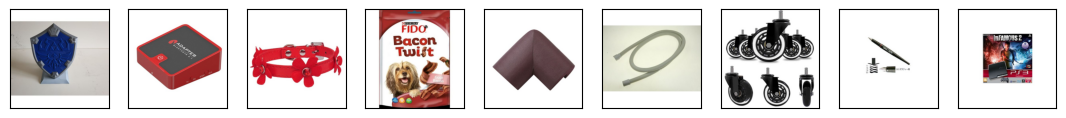

----------------------------------------------------------------------------------------------------------------------------------------------------


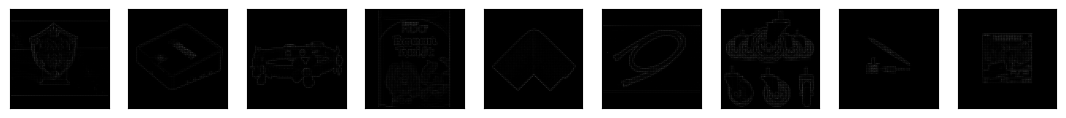

In [86]:
hog_ims = [hog(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY), visualize=True)[1] for im in images]
images_grid(images[:9], 1, 9)
print('-'*148)
images_grid(hog_ims[:9], 1, 9 , cmap='gray')

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>3.5 Descripteurs SIFT et Bag of Visual Words</h2>

<p>
En complément des features précédemment introduites, nous utilisons le
transformateur <code>BoVWTransformer</code>, basé sur le principe du
<b>Bag of Visual Words (BoVW)</b>.
</p>

<p>
Le <b>Bag of Visual Words</b> représente une image sous la forme d’un
<b>histogramme de motifs locaux</b>, appelés <b>mots visuels</b>. La démarche
consiste d’abord à extraire des <b>points clés</b> dans l’image ainsi que leurs
descripteurs associés, ici des <b>SIFT</b>, puis à regrouper ces descripteurs afin
de construire un <b>dictionnaire de mots visuels</b>. Chaque image est ensuite
décrite par la fréquence d’apparition de ces mots, ce qui permet de comparer et
de classer les images de manière efficace.
</p>

<p>
Les <b>descripteurs SIFT</b> (<em>Scale-Invariant Feature Transform</em>) capturent
les motifs locaux autour des points clés de façon <b>robuste aux variations
d’échelle, de rotation et d’illumination</b>. Ils sont particulièrement adaptés
pour représenter des structures locales complexes et complètent efficacement
les descripteurs de forme et de texture précédemment étudiés.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h1 align="center">IV. Réduction de la dimension</h1>

<h2>4.1 Projection LDA</h2>

<p>
Dans cette section, nous abordons la <b>réduction de dimension</b> appliquée aux
représentations visuelles. Les images sont préalablement
<b>redimensionnées à 36&nbsp;×&nbsp;36 pixels</b>, puis projetées dans un espace de
dimension plus faible à l’aide d’une <b>Linear Discriminant Analysis (LDA)</b>.
</p>

<p>
La LDA repose sur des <b>combinaisons linéaires des pixels</b> visant à
<b>maximiser la séparation entre les catégories</b> tout en
<b>minimisant la variance intra-classe</b>. Contrairement aux méthodes non
supervisées, cette approche exploite directement l’information des labels, ce
qui la rend particulièrement adaptée à une tâche de classification.
</p>

<p>
Nous visualisons ici la projection des images sur les <b>deux premières
composantes discriminantes</b>, afin d’évaluer la capacité de cette représentation
compacte à structurer les catégories et à révéler d’éventuelles séparations
visuelles.
</p>

</div>



In [94]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

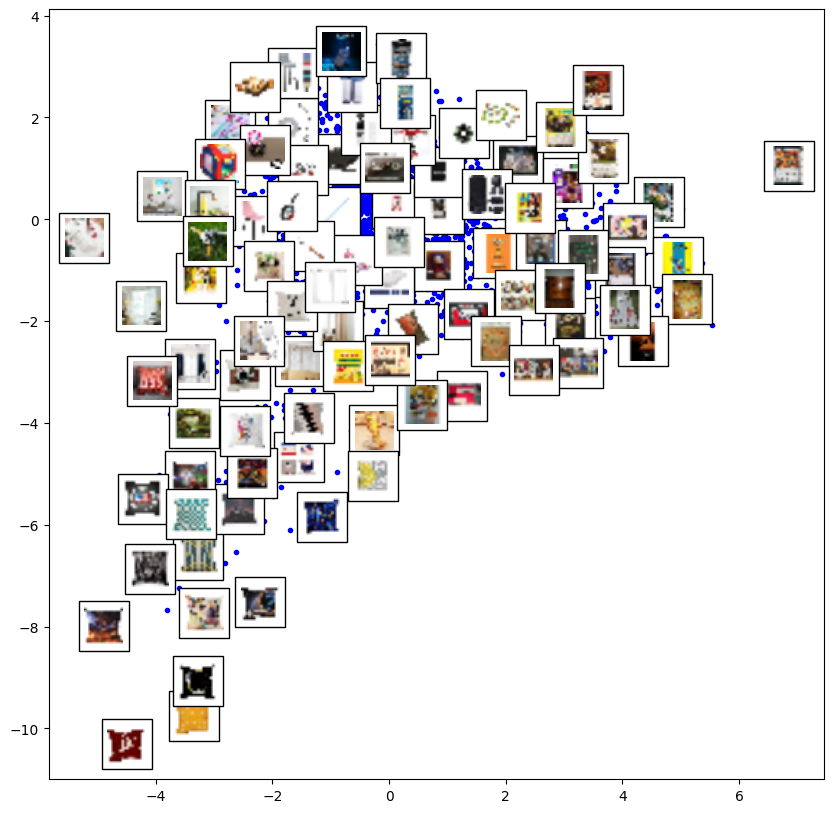

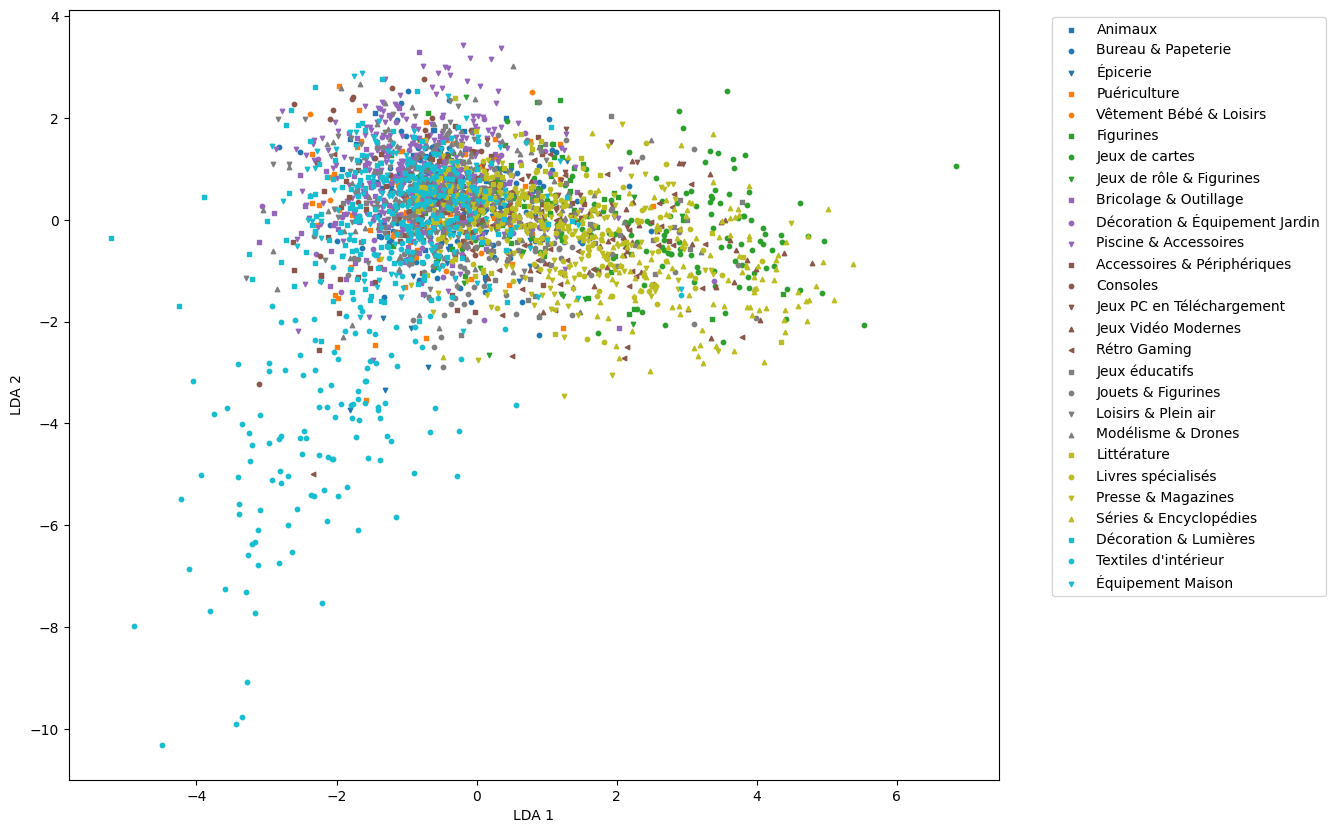

In [96]:
import matplotlib.markers as mmarkers

N = 3000
im28x28 = images_read(df['image'].iloc[:N], dsize=(16,16))
im28x28 = im28x28.reshape((im28x28.shape[0], -1))
lda = LDA(n_components=2)
lda.fit(im28x28, df['prdtypecode'][:N])
imt = lda.transform(im28x28)
fig, ax = plt.subplots(figsize=(10, 10))

# pour le nuage de points avec les images
plot_components(imt, lda, im28x28.reshape((-1,16,16,3)), prefit=True, ax=ax, thumb_frac=0.05)


# pour le deuxième nuage de points
data = pd.DataFrame({
    'x': imt[:, 0],
    'y': imt[:, 1],
    'groupe': df['group'].iloc[:len(imt)],
    'categorie': df['category'].iloc[:len(imt)]
})

groups = sorted(data['groupe'].unique())

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in np.linspace(0, 1, len(groups))]
markers = list(mmarkers.MarkerStyle.markers.keys())[1:]

plt.figure(figsize=(12,10))

for i, group in enumerate(groups):
    cats = sorted(data[data['groupe']==group]['categorie'].unique())
    for j, cat in enumerate(cats):
        subset = data[(data["categorie"] == cat) & (data["groupe"] == group)]
        plt.scatter(subset["x"], subset['y'], color=colors[i], marker=markers[j], label=cat, s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.show()

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
La projection met en évidence une séparation partielle des catégories. La
catégorie <strong>Textiles d’intérieur</strong> se distingue nettement, apparaissant
regroupée en bas à gauche du plan. Cette séparation est principalement portée
par des images de <strong>coussins</strong> et d’<strong>oreillers</strong>, dont les
caractéristiques visuelles sont relativement homogènes.
</p>

<p>
À l’inverse, la zone située en haut à droite du graphique regroupe majoritairement
des objets de forme <strong>rectangulaire</strong>, tels que des <strong>livres</strong>
ou des <strong>revues</strong>, reflétant des structures visuelles communes entre
plusieurs catégories.
</p>

<p>
Bien que la séparation globale reste limitée, cette visualisation montre que la
<strong>LDA appliquée directement aux images brutes</strong> capture certaines
structures discriminantes. Nous pouvons ainsi utiliser les composantes issues de
la LDA comme <strong>features supplémentaires</strong> dans notre pipeline de
classification.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>V - Modèle de base</h2>

<p>
Nous mettons en place un <b>premier modèle de référence</b> basé exclusivement sur
les <b>features visuelles</b> extraites des images produits. Ce modèle a pour but
de fournir un <b>baseline</b> permettant d’évaluer la contribution des images
seules, avant l’introduction de modèles plus complexes et de stratégies de
fusion.
</p>

<p>
Les images sont traitées à l’aide d’un <b>pipeline scikit-learn</b> structuré autour
d’une <code>FeatureUnion</code>, combinant plusieurs familles de descripteurs
complémentaires :
</p>

<ul>
  <li><b>Descripteurs de structure</b> en niveaux de gris (HOG, motifs géométriques,
      BoVW),</li>
  <li><b>Descripteurs de couleur</b> (histogrammes RGB, contrastes inter-canaux,
      proportions de couleurs dominantes),</li>
  <li><b>Projection supervisée</b> via une Linear Discriminant Analysis (LDA).</li>
</ul>

<p>
Un <b>prétraitement global</b> est appliqué en amont (recadrage automatique et
redimensionnement), puis l’ensemble des features est <b>concaténé et normalisé</b>
afin d’obtenir une représentation visuelle dense et homogène.
</p>

<p>
Sur ces features, nous entraînons une <b>régression logistique</b> utilisée comme
<b>modèle de base</b>. Ce choix permet d’obtenir un classifieur simple,
interprétable et rapide à entraîner, servant de point de comparaison pour la
suite du projet.
</p>

<h3>5.1 - Optimisation du paramètre de régularisation C</h3>

<p>
Le paramètre de <b>régularisation <code>C</code></b> de la régression logistique est
<b>optimisé sur le jeu de validation</b>, afin de trouver le meilleur compromis
entre biais et variance, avant une évaluation finale sur le jeu de test.
</p>

</div>


In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_val = target_encoder.transform(y_val)
y_test = target_encoder.transform(y_test)

features_pipeline = build_image_features_pipeline()

In [21]:

# on va charger 20 000 images du jeu d'entraînement environ 500 Mo en 128x128x3 (à adapter) 
N = 20000
batch_idx, _ = train_test_split(range(len(y_train)), train_size=N, stratify=y_train)
X_train_batch = images_read(X_train.iloc[batch_idx]['image_path'], dsize=(128, 128), max_load=3*10**9)
y_train_batch = y_train[batch_idx]

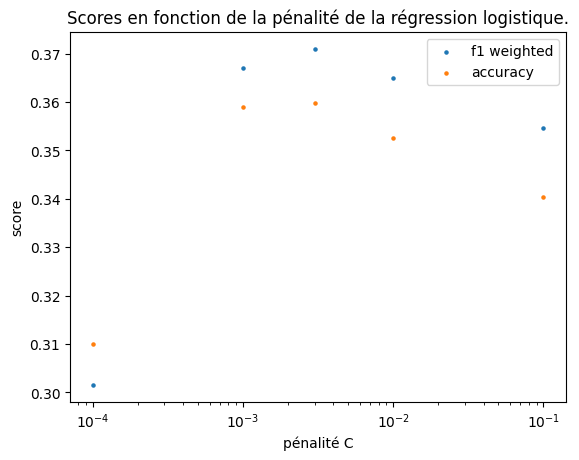

In [35]:
# validation pour le coefficient C

val_batch_size = 500

results = []
best_f1 = 0
best_model = None

for C in [0.1, 0.01, 0.003, 0.001, 0.0001]:
    features = build_image_features_pipeline()
    pipeline = Pipeline([
        ('features', features),
        ('classifier', LogisticRegression(
            max_iter=12000,
            C=C,
            class_weight='balanced'
        ))
    ])
    start_train = time.time()
    pipeline.fit(X_train_batch, y_train_batch)
    train_time = time.time() - start_train
    y_preds = []
    start_pred = time.time()
    for start_idx in range(0, len(X_val), val_batch_size):
        end_idx = start_idx + val_batch_size
        if end_idx > len(X_val):
            X_val_batch = images_read(X_val.iloc[start_idx:]['image_path'], dsize=(128, 128))
        else:
            X_val_batch = images_read(X_val.iloc[start_idx:end_idx]['image_path'], dsize=(128, 128))
        y_preds.append(pipeline.predict(X_val_batch))
    y_preds = np.hstack(y_preds)
    pred_time = time.time() - start_pred
    f1 = f1_score(y_val, y_preds, average="weighted")
    if f1 > best_f1:
        best_model = pipeline
        best_f1 = f1
    results.append({
        'C' : C,
        'val f1 weighted' : f1_score(y_val, y_preds, average="weighted"),
        'val accuracy' : accuracy_score(y_val, y_preds),
        "train_time_s": train_time,
        "pred_time_s": pred_time,
    })

results = pd.DataFrame(results).sort_values('C')

plt.scatter(results['C'], results['val f1 weighted'], s=5, label='f1 weighted')
plt.scatter(results['C'], results['val accuracy'], s=5, label='accuracy')
plt.title("Scores en fonction de la pénalité de la régression logistique.")
plt.xlabel('pénalité C')
plt.ylabel('score')
plt.legend()
plt.xscale('log');

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les performances du modèle augmentent nettement lorsque le paramètre de
régularisation <code>C</code> passe de valeurs très faibles à des valeurs
intermédiaires, traduisant la sortie d’un régime de sous-apprentissage.
</p>

<p>
Un maximum du <b>F1 pondéré</b> est observé autour de <code>C = 0.003</code>. Ce paramètre est donc retenu pour la suite comme <b>valeur optimale de
régularisation</b> pour le modèle de base de régression logistique.
</p>

<h3>5.2 - Évaluation du modèle sur le jeu de test</h3>

<p>
Nous évaluons maintenant ce modèle optimisé sur le <b>jeu de test</b> afin de
mesurer ses performances finales.
</p>

</div>


In [73]:
y_proba, y_preds = [], []
test_batch_size = 500

for start_idx in range(0, len(X_test), test_batch_size):
    end_idx = start_idx + test_batch_size

    X_test_batch = images_read(
        X_test.iloc[start_idx:end_idx]['image_path'],
        dsize=(128, 128)
    )

    p = best_model.predict_proba(X_test_batch)

    y_proba.append(p)
    y_preds.append(np.argmax(p, axis=1))

y_proba = np.vstack(y_proba)
y_preds = np.hstack(y_preds)

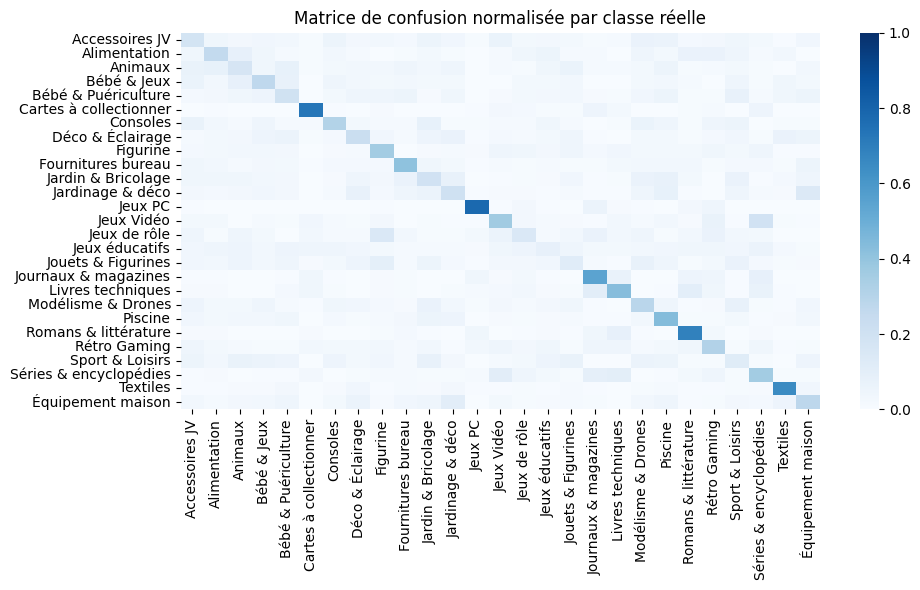


📈 Classes avec les meilleurs scores F1 (top 5)


precision  recall  f1-score  support
Cartes à collectionner      0.746   0.727     0.736    593.0
Textiles                    0.687   0.652     0.669    646.0
Romans & littérature        0.529   0.691     0.599    414.0
Journaux & magazines        0.578   0.549     0.563    714.0
Jeux PC                     0.436   0.779     0.559    131.0


📉 Classes avec les plus faibles scores F1 (bottom 5)


precision  recall  f1-score  support
Bébé & Jeux          0.088   0.273     0.133    121.0
Sport & Loisirs      0.107   0.120     0.113    374.0
Animaux              0.061   0.169     0.090    124.0
Jeux éducatifs       0.092   0.084     0.088    311.0
Jeux de rôle         0.060   0.148     0.086    115.0


❌ Confusions les plus fréquentes (top 5)


Classe réelle          Classe prédite  \
0         Jeux Vidéo  Séries & encyclopédies   
1       Jeux de rôle                Figurine   
2   Jardinage & déco       Équipement maison   
3  Livres techniques    Journaux & magazines   
4  Équipement maison        Jardinage & déco   

   % des prédictions de la classe réelle  
0                                   19.2  
1                                   14.8  
2                                   13.9  
3                                   10.9  
4                                   10.8

In [125]:
plot_classification_report(y_test, y_preds, encoder=target_encoder, k_best_f1=5)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les résultats montrent que les <b>images seules</b> permettent de bien discriminer
certaines catégories. Les meilleures performances sont obtenues pour
<strong>Cartes à collectionner</strong>, <strong>Textiles</strong>,
<strong>Romans &amp; littérature</strong> et <strong>Journaux &amp; magazines</strong>,
avec des scores F1 élevés. Ces catégories présentent des
<b>structures visuelles homogènes</b> (formats rectangulaires, motifs répétitifs,
textures ou couleurs dominantes) que le modèle parvient à exploiter efficacement.
</p>

<p>
À l’inverse, les catégories telles que <strong>Animaux</strong>,
<strong>Jeux éducatifs</strong>, <strong>Jeux de rôle</strong> ou
<strong>Sport &amp; Loisirs</strong> affichent les <b>scores F1 les plus faibles</b>.
Ces classes regroupent des images visuellement très hétérogènes, avec des objets
de formes, de tailles et de contextes variés, ce qui rend leur discrimination
plus difficile à partir des seules informations visuelles.
</p>

<p>
L’analyse des <b>confusions les plus fréquentes</b> confirme ces observations :
les erreurs se produisent majoritairement entre des catégories
<b>visuellement proches</b>, comme <strong>Livres techniques</strong> et
<strong>Journaux &amp; magazines</strong>, ou encore entre
<strong>Jardinage &amp; déco</strong> et <strong>Équipement maison</strong>. Ces
confusions traduisent des similitudes de formats, de couleurs ou de mises en
scène des produits.
</p>

<p>
Globalement, ces résultats sont cohérents avec l’analyse exploratoire menée
précédemment&nbsp;: les catégories disposant de <b>signatures visuelles fortes</b>
(formes marquées, couleurs dominantes, structures répétitives) obtiennent de
meilleures performances, tandis que celles à forte variabilité visuelle restent
plus complexes à prédire. Ce modèle image constitue ainsi une
<b>base pertinente</b>, mais souligne la nécessité d’intégrer d’autres modalités
(texte, métadonnées ou fusion de modèles) pour améliorer les performances
globales.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>5.3 - Analyse de l’importance des features</h3>

<p>Nous allons maintenant analyser l'importance des features dans le modèle, en examinant la valeur absolue des coefficients, qui sont représentées sur les heatmaps ci-dessous.</p>

</div>

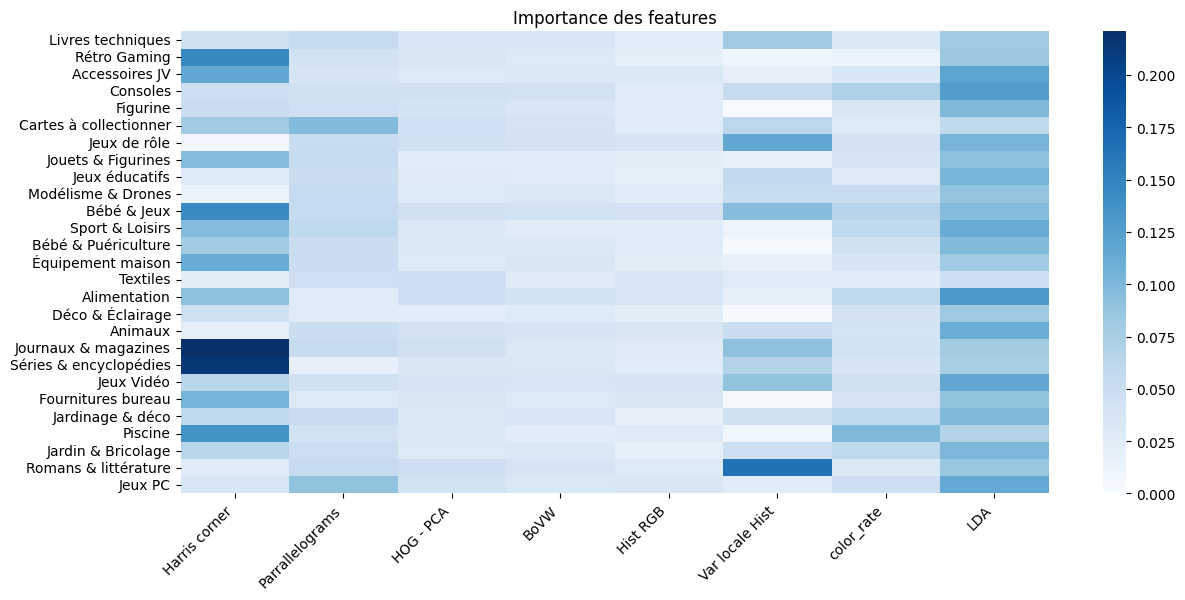

In [127]:
ranges = {
    'Harris corner' : range(0,1),
    'Parrallelograms' : range(1,5),
    'HOG - PCA' : range(5, 155),
    'BoVW' : range(155, 255),
    'Hist RGB' : range(255, 303),         # 48 features (3*16 bins)
    'Var locale Hist' : range(303, 304),
    'color_rate' : range(304, 313),       # 9 features
    'LDA' : range(313, 339),
}
coef = best_model.named_steps['classifier'].coef_


# ici reprendre et ajouter 
classes = target_encoder.inverse_transform(best_model.classes_)
plot_features_importance(coef, ranges, classes, by_block=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Le graphique d’<b>importance moyenne des features par bloc</b> met en évidence des
contributions différenciées selon les familles de descripteurs. Les
<b>coins de Harris</b> apparaissent comme particulièrement importants pour la
discrimination des catégories <strong>Journaux &amp; magazines</strong> et
<strong>Séries &amp; encyclopédies</strong>, ce qui est cohérent avec la présence
marquée de structures anguleuses liées aux mises en page, aux textes et aux
bordures.
</p>

<p>
Les <b>comptes de parallélogrammes</b> présentent une influence plus modérée mais
néanmoins significative, notamment pour les catégories
<strong>Jeux PC</strong> et <strong>Cartes à collectionner</strong>. Cette observation
est en accord avec l’analyse exploratoire, ces catégories étant majoritairement
composées d’objets de forme rectangulaire (boîtiers, cartes).
</p>

<p>
La <b>variance locale</b> contribue fortement à la discrimination de la classe
<strong>Romans &amp; littérature</strong>. Cette catégorie se caractérise par des
images présentant de nombreux contrastes locaux et des pics marqués dans les
histogrammes, ce qui rend cette feature particulièrement informative.
</p>

<p>
Les composantes issues de la <b>LDA</b> présentent également une importance
globale élevée. Cette observation est toutefois à interpréter avec prudence&nbsp;:
la LDA étant une méthode supervisée optimisant directement la séparation entre
classes, il est attendu que ses composantes portent une information fortement
discriminante et donc un poids important dans le modèle.
</p>

<p>
Enfin, les descripteurs de type <b>HOG avec PCA</b> (150 dimensions) et
<b>Bag of Visual Words</b> (100 dimensions) affichent une importance plus
<b>diluée</b> à l’échelle du bloc. Leur contribution est répartie sur un grand
nombre de dimensions, ce qui réduit mécaniquement le poids moyen de chaque
feature, sans pour autant remettre en cause leur intérêt global pour la
représentation des formes et textures.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>5.4 - Calibration et exports</h3>

<p>
L’analyse de l’importance des features met en évidence que le modèle image
s’appuie sur des signaux visuels pertinents et complémentaires. Toutefois, bien
que la régression logistique produise directement des probabilités, celles-ci ne
sont pas nécessairement <b>bien calibrées</b>, en particulier dans un contexte
multi-classes et de fusion de modèles.
</p>

<p>
Afin de garantir une <b>échelle probabiliste cohérente</b> et exploitable pour les
étapes ultérieures de <b>fusion et de stacking</b>, nous appliquons une
<b>calibration des probabilités</b> sur les sorties du modèle de base. Cette
calibration permet d’aligner les scores prédits avec des probabilités plus
fidèles aux fréquences observées.
</p>

<p>
Une fois la calibration effectuée, nous procédons à l’<b>enregistrement du modèle
image de base</b> ainsi qu’à la <b>sauvegarde des probabilités calibrées</b>
produites par le modèle calibré. Ces éléments seront réutilisés ultérieurement
pour construire des modèles de fusion, sans avoir à réentraîner le classifieur
image.
</p>

</div>



In [133]:
calibrated_model = CalibratedClassifierCV(
    estimator=FrozenEstimator(best_model),
    method="sigmoid"
)

calibrated_model.fit(X_train_batch, y_train_batch)

for split_name, X in [("val", X_val), ("test", X_test)]:
    y_proba = []

    for start_idx in range(0, len(X), 500):
        X_batch = images_read(
            X.iloc[start_idx:start_idx+500]["image_path"],
            dsize=(128, 128)
        )
        y_proba.append(calibrated_model.predict_proba(X_batch))

    y_proba = np.vstack(y_proba)
    np.save(f"../predictions/image/proba_cal_lr_{split_name}.npy", y_proba)

In [134]:
# enregistrement du modèle
import joblib

joblib.dump(best_model, '../models/image/logistic_regression.joblib')
joblib.dump(calibrated_model, '../models/image/calibrated_logistic_regression.joblib')

['../models/image/calibrated_logistic_regression.joblib']

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h1 align="center">Conclusion</h1>

<p>
Ce notebook a permis de mener une <b>analyse approfondie des images</b> du jeu de
données et d’évaluer leur contribution à la tâche de classification. Les étapes
d’exploration ont mis en évidence des <b>signatures visuelles discriminantes</b>
selon les catégories, qu’il s’agisse de couleurs dominantes, de structures
rectangulaires, de textures ou de motifs locaux.
</p>

<p>
Sur la base de ces observations, un <b>premier modèle de référence</b> fondé
exclusivement sur des <b>features visuelles</b> a été construit. Il combine
plusieurs familles de descripteurs complémentaires (couleur, forme, texture,
points d’intérêt, projection LDA), permettant de capturer différents niveaux
d’information présents dans les images.
</p>

<p>
Les résultats obtenus montrent que certaines catégories disposant de
<b>caractéristiques visuelles fortes et homogènes</b> (cartes à collectionner,
textiles, livres) sont correctement discriminées par le modèle image, tandis que
d’autres catégories plus hétérogènes restent difficiles à prédire à partir des
images seules. L’analyse des confusions et des importances de features confirme
ces constats et apporte une meilleure interprétabilité du modèle.
</p>

<p>
Enfin, les probabilités produites par le modèle ont été <b>calibrées</b> puis
sauvegardées, afin de garantir une échelle probabiliste cohérente et exploitable
pour la suite du projet. Ce modèle image constitue ainsi un <b>baseline solide</b>
et une base fiable pour les prochaines étapes, en particulier l’intégration
d’autres modalités et la mise en œuvre de <b>stratégies de fusion et de stacking</b>
visant à améliorer les performances globales.
</p>

</div>
